# Baseline

## Общая инициализация
Нужно выполнить в самом начале независимо от дальнейших действий

### Путь к каталогу, в котором лежит датасет
датасет представлен файлом `train.csv` и папкой `train`

In [2]:
base_folder = "/kaggle/input/itmo-acoustic-event-detection-2023/"

#### Инициализация путей 

In [7]:
import os.path as path

In [19]:
# path
train_folder = path.join(base_folder, "audio_train/train/")
train_csv = path.join(base_folder, "train.csv")
train_pickle = path.join('', "train.pickle")
test_folder = path.join(base_folder, "audio_test/test/")
# test_csv = path.join(base_folder, "train.csv")
test_pickle = path.join('', "test.pickle")

### Изучение аудиофайлов датасета

In [9]:
#!pip install librosa
import os
import random

import librosa
import librosa.feature as F

import numpy as np

import matplotlib.pyplot as plt

from IPython.display import Audio

In [10]:
# random filename from dir
files = os.listdir(train_folder)
filename = random.choice(files)
filename

'ff1444a6a88e75b6a353.wav'

#### Спектрограмма

In [11]:
# spectrogram parameters
sample_rate = 11025

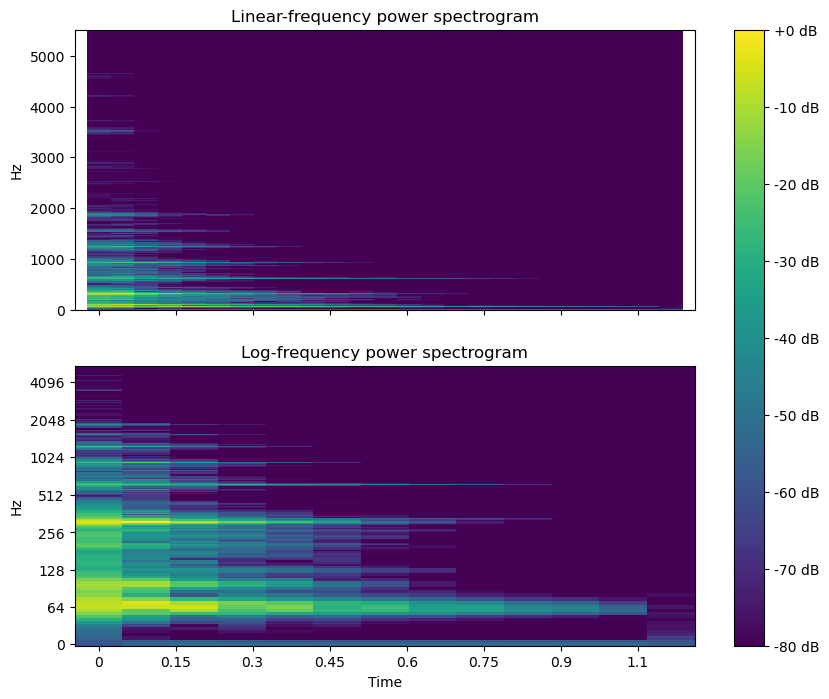

In [12]:
wav_data, sr = librosa.load(os.path.join(train_folder, filename), sr=sample_rate)

fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
cmap = "viridis"

# draw linear-frequency spectrogram
hop_length = 512
wav_data_db = librosa.amplitude_to_db(
    np.abs(librosa.stft(wav_data, hop_length=hop_length)),
    ref=np.max
)
img1 = librosa.display.specshow(
    wav_data_db,
    sr=sr,
    hop_length=hop_length,
    ax=ax_top,
    x_axis='time',
    y_axis='linear',
    cmap=cmap,
)
ax_top.set(title='Linear-frequency power spectrogram')
ax_top.label_outer()

# draw log-frequency spectrogram
hop_length = 1024
wav_data_db = librosa.amplitude_to_db(
    np.abs(librosa.stft(wav_data, hop_length=hop_length)),
    ref=np.max
)
img2 = librosa.display.specshow(
    wav_data_db,
    sr=sr,
    hop_length=hop_length,
    ax=ax_bottom,
    x_axis='time',
    y_axis='log',
    cmap=cmap,
)
ax_bottom.set(title='Log-frequency power spectrogram')
ax_bottom.label_outer()

fig.colorbar(img1, ax=[ax_top, ax_bottom], format="%+2.f dB")
plt.show()

display(Audio(wav_data, rate=sr))

#### Mel-спектрограмма

In [14]:
# melspectrogram parameters
sample_rate = 11025
n_fft = 1024
overlap = 4
hop_length = n_fft // overlap
n_mels = 64

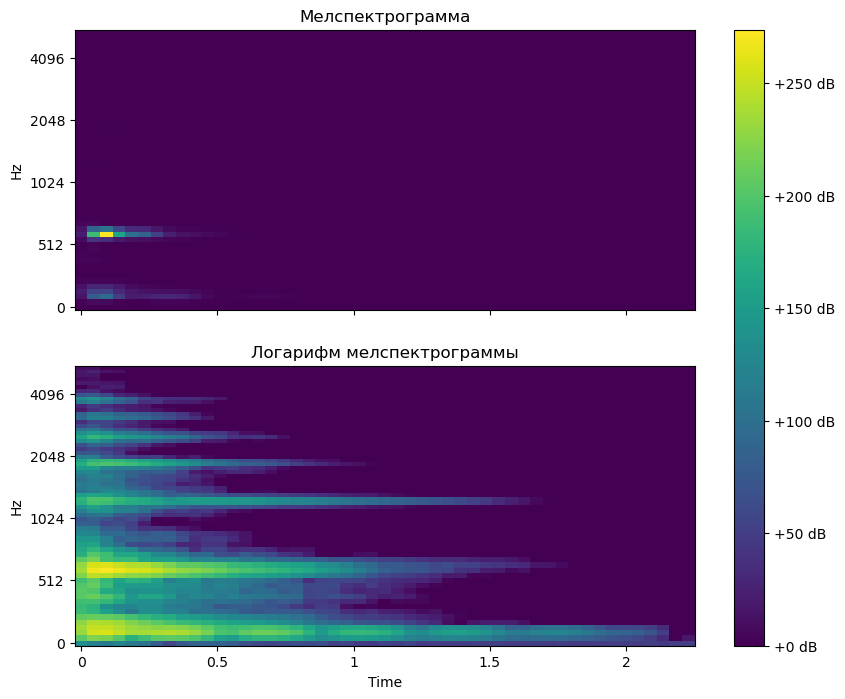

In [15]:
wav_data, sr = librosa.load(os.path.join(train_folder, filename), sr=sample_rate)

mel_spec = F.melspectrogram(
    y=wav_data,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels, 
    fmax=sample_rate // 2
)

fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
cmap = "viridis"

img1 = librosa.display.specshow(
    mel_spec,
    sr=sr,
    fmax=sr // 2,
    ax=ax_top,
    x_axis='time',
    y_axis='mel',
    cmap=cmap,
)
ax_top.set(title='Мелспектрограмма')
ax_top.label_outer()

D = librosa.power_to_db(mel_spec, ref=np.max)
img2 = librosa.display.specshow(
    D,
    sr=sr,
    fmax=sr // 2,
    ax=ax_bottom,
    x_axis='time',
    y_axis='mel',
    cmap=cmap,
)
ax_bottom.set(title='Логарифм мелспектрограммы')
ax_bottom.label_outer()

fig.colorbar(img1, ax=[ax_top, ax_bottom], format="%+2.f dB")
plt.show()

display(Audio(wav_data, rate=sr))

## Извлечение признаков

In [16]:
import os
import pickle
from enum import Enum
from typing import NoReturn, Optional

from tqdm import tqdm

import pandas as pd
import numpy as np

import librosa
import librosa.feature as F


class SetType(Enum):
    """Set type"""
    TRAIN = 1
    TEST  = 2
    DEV   = 3


def extract_log_mel_feats(set_type:SetType, path_to_csv:str, path_to_files:str,
                          out_path:str, labels_pickle:str, sr:Optional[int], n_fft:int,
                          hop_length:int, n_mels:int):
    """
    Extract features from given files and store them in binary format.

    :param set_type: set tyle
    :param path_to_csv: path to loaded csv
    :param path_to_files: path to loaded data
    :param out_path: path to store extracted features
    :param labels_pickle: path to store labels dictionary
    :param sr: input files sample rate
    :param n_fft: size of fft window
    :param hop_length: hop size
    :param n_mels: number of mel band

    :return:
    """
    if set_type not in [SetType.TRAIN, SetType.TEST]:
        raise Exception(f'Such set type not supported: {set_type}')

    feats = []

    if set_type == SetType.TRAIN:
        meta = pd.read_csv(path_to_csv, skiprows=1, names=['fname', 'label'])

        file_names = list(meta['fname'])
        n_files = len(file_names)
        labels = list(meta['label'])

        uniq_labels = np.sort(np.unique(labels))
        label_to_id = {label: i for i, label in enumerate(uniq_labels)}

        print('Total files:', n_files)

        for i, (file_name, label) in tqdm(enumerate(zip(file_names, labels))):
            wav_data, sr = librosa.load(os.path.join(path_to_files, file_name), sr=sr)
            mel_spec = F.melspectrogram(
                y=wav_data,
                n_fft=n_fft,
                hop_length=hop_length,
                n_mels=n_mels,
                fmax=sr // 2
            )
            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
                'label_id': label_to_id[label]
            })

        pickle.dump(feats, open(out_path, 'wb'))
        pickle.dump(label_to_id, open(labels_pickle, 'wb'))
        return label_to_id
    else:
        for i, file_name in tqdm(enumerate(os.listdir(path_to_files))):
            wav_data, sr = librosa.load(os.path.join(path_to_files, file_name), sr=sr)
            if len(wav_data) == 0:
                wav_data = np.zeros(sr)
            mel_spec = F.melspectrogram(
                y=wav_data,
                n_fft=n_fft,
                hop_length=hop_length,
                n_mels=n_mels,
                fmax=sr // 2
            )
            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
            })

        pickle.dump(feats, open(out_path, 'wb'))
        return

In [17]:
# feature extraction parameters
sample_rate = 11025
n_fft = 1024
overlap = 4
hop_length = n_fft // overlap
n_mels = 64

In [20]:
# extract features and store to `train_pickle` extracted features
label_to_id = extract_log_mel_feats(
    SetType.TRAIN,
    train_csv, 
    train_folder, 
    train_pickle,
    labels_pickle,
    sample_rate, 
    n_fft, 
    hop_length, 
    n_mels
)

label_to_id = extract_log_mel_feats(
    SetType.TEST,
    test_csv, 
    test_folder, 
    test_pickle,
    labels_pickle,
    sample_rate, 
    n_fft, 
    hop_length, 
    n_mels
)

id_to_label = [label for label, i in label_to_id.items()]

Total files: 5683


5683it [02:00, 47.19it/s]


OSError: [Errno 30] Read-only file system: '/kaggle/input/itmo-acoustic-event-detection-2023/labels.pickle'

## Алгоритм детектирования

### Подготовительный этап

In [30]:
from typing import NoReturn
from pprint import pprint
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [31]:
device = device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [32]:
cpu_count = os.cpu_count()

num_workers = cpu_count if device == "cpu" else 0
num_workers, cpu_count

(0, 12)

#### Добиваемся максимальной воспроизводимости
Согласно данному мануалу: https://pytorch.org/docs/stable/notes/randomness.html

In [33]:
def set_random_state(random_state:int=0) -> NoReturn:
    """Initialize random generators.

    Parameters
    ==========
    random_state : int = 0
        Determines random number generation for centroid initialization.
        Use an int to make the randomness deterministic.
    """
    torch.manual_seed(random_state)
    random.seed(random_state)
    np.random.seed(random_state)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_state)
        torch.cuda.manual_seed(random_state)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [34]:
random_state = 42

In [35]:
set_random_state(random_state)

In [36]:
torch.use_deterministic_algorithms(True)

In [37]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8
%env PYTHONHASHSEED=42

env: CUBLAS_WORKSPACE_CONFIG=:4096:8

env: PYTHONHASHSEED=42


### Архитектура нейронной сети

In [39]:
class DummyNetwork(nn.Module):
    """Neural network base architecture"""
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,  out_channels=64, kernel_size=5, stride=(2, 2), device=device)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=(1, 1), device=device)
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=(1, 1), device=device)

        # ouput_shape = 1

        # output_shape = 1 + (output_shape - kernel_size) + / (stride)

        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.3)
        
        self.bn1 = nn.BatchNorm2d(num_features=64, device=device)
        self.bn2 = nn.BatchNorm2d(num_features=96, device=device)
        self.bn3 = nn.BatchNorm2d(num_features=64, device=device)

        self.flat = nn.Flatten()

        # 33856 - должно соответствовать форме self.flat
        self.fc1 = nn.Linear(33856, 41, device=device)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout3(x)

        x = self.flat(x)

        # здесь можно еще добавить полносвязный слой или слои
        x = self.fc1(x)

        return x

In [40]:
set_random_state(random_state) # try to run this cell several times
                               # then comment this line and run it several times again
                               # * pay attention at tensors values

# random 4D tensor
random_input = torch.randn(1, 1, 64, 64, requires_grad=True, device=device)

print(f"Исходный тензор {list(random_input.shape)}:")
pprint(random_input)

# create neural network instance
network = DummyNetwork()

# pass data throught the neural network
output = network(random_input)

print(f"\nТензор на выходе нейронной сети {list(output.shape)}:")
pprint(output)

Исходный тензор [1, 1, 64, 64]:

tensor([[[[ 0.1940,  2.1614, -0.1721,  ..., -0.8146,  0.2502, -0.4273],

          [ 1.1044, -1.1028,  0.5543,  ..., -1.2072, -0.2438, -0.6784],

          [ 0.1973,  0.9782, -0.0287,  ..., -0.1266, -0.4321, -1.3943],

          ...,

          [-1.1998,  0.5818, -0.7198,  ..., -0.6079, -1.8145,  0.2807],

          [-0.0970,  0.9319, -0.4393,  ..., -0.1155, -0.0528,  1.1175],

          [ 3.0098,  1.3304, -1.1632,  ...,  0.1124,  0.2769, -1.2535]]]],

       device='cuda:0', requires_grad=True)



Тензор на выходе нейронной сети [1, 41]:

tensor([[-0.0980, -1.0194, -0.0221,  0.9005, -0.8396, -0.4789,  0.7319, -0.2394,

          0.7614, -0.6676,  0.3395,  0.4804, -1.0155,  1.4160,  0.6132,  1.0010,

         -0.4230,  1.6571,  0.5516,  0.9317, -0.5682, -1.0172, -0.9999,  1.1372,

          0.7438, -0.0974,  0.1077,  1.2856,  0.3204, -0.6904,  0.6182,  0.5944,

          0.2135, -0.7912, -1.1697, -0.4749,  0.6904,  0.5845,  0.6890,  1.4156,

         -1

### Шаг оптимизации

In [41]:
import torch.optim as optim

In [42]:
set_random_state(random_state)


# choose loss function
criterion = nn.CrossEntropyLoss()

# choose and tune optimizer
optimizer = optim.SGD(network.parameters(), lr=0.001)
optimizer.zero_grad()

random_input = torch.randn(3, 1, 64, 64, requires_grad=True, device=device)
print(f"Тензор на входе сети {list(random_input.shape)}:")
pprint(random_input)

output = network(random_input)
print(f"\nТензор на выходе сети {list(output.shape)}:")
pprint(output)

target = torch.randint(5, (3,), dtype=torch.long, device=device)
print(f"\nТензор с целевыми значениями {list(target.shape)}:")
pprint(target)

loss = criterion(output, target)
print("\nЗначение функции потерь:", loss.item())

# backpropagation
loss.backward()

# next step
optimizer.step() 

Тензор на входе сети [3, 1, 64, 64]:

tensor([[[[ 0.1940,  2.1614, -0.1721,  ..., -0.8146,  0.2502, -0.4273],

          [ 1.1044, -1.1028,  0.5543,  ..., -1.2072, -0.2438, -0.6784],

          [ 0.1973,  0.9782, -0.0287,  ..., -0.1266, -0.4321, -1.3943],

          ...,

          [-1.1998,  0.5818, -0.7198,  ..., -0.6079, -1.8145,  0.2807],

          [-0.0970,  0.9319, -0.4393,  ..., -0.1155, -0.0528,  1.1175],

          [ 3.0098,  1.3304, -1.1632,  ...,  0.1124,  0.2769, -1.2535]]],





        [[[ 1.1346, -0.6329, -0.9147,  ..., -1.5122, -1.1374,  0.7628],

          [ 0.9661, -0.0587, -0.2129,  ...,  1.2377,  0.5842,  1.6728],

          [ 0.7942,  0.3131, -0.3607,  ...,  0.1261, -0.1309,  2.0342],

          ...,

          [-0.3319,  0.8590,  0.7535,  ..., -1.2910, -0.3644,  0.9805],

          [-0.5130,  0.6719, -0.1551,  ..., -0.4551, -0.1417, -1.2772],

          [-0.4063,  0.0820,  0.8311,  ..., -1.0449,  1.5397, -2.0042]]],





        [[[-0.5852, -0.9346,  0.9684,  ...

### Обучение нейронной сети

#### Загрузка ранее извлеченных признаков и подготовка данных для обучения

In [43]:
import pickle

In [45]:
train_data = pickle.load(open(train_pickle, "rb"))

label_to_id = pickle.load(open(labels_pickle, "rb"))
id_to_label = [label for label, i in label_to_id.items()]

In [46]:
def prepare_shape(feature):
    tmp = feature
    N = 64 # размер во времени (можно увеличить, должно стать лучше)
    while tmp.shape[1] < N:
        # можно попробовать сделать np.pad для коротких файлов, вместо повторения до необходимой длины
        tmp = np.hstack((tmp, tmp))
    # случайный сдвиг должен улучшить результат (для этого нужно функцию перенести в EventDetectionDataset)
    tmp = tmp[np.newaxis, :, :N]
    return tmp

In [82]:
# можно улучшить, используя сбалансированное валидационное множество
# гуглить stratified train test split sklearn
# validation_set_size = 800

# x_val = []
# y_val = []

# x_tr = []
# y_tr = []

# for i, row in enumerate(train_data):
#     feature = prepare_shape(row['feature'])
#     if i < validation_set_size:
#         x_val.append(feature)
#         y_val.append(row['label_id'])
#     else:
#         x_tr.append(feature)
#         y_tr.append(row['label_id'])


from sklearn.model_selection import StratifiedShuffleSplit

features = [row['feature'] for i, row in enumerate(train_data)]
labels = [row['label_id'] for i, row in enumerate(train_data)]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
splt = list(sss.split(features, labels))
train_indices, val_indices = splt[0][0], splt[0][1]


x_val = [prepare_shape(features[i]) for i in val_indices]
y_val = [labels[i] for i in val_indices]

x_tr = [prepare_shape(features[i]) for i in train_indices]
y_tr = [labels[i] for i in train_indices]

x_val = np.asarray(x_val)
x_tr = np.asarray(x_tr)

y_val = np.asarray(y_val)
y_tr = np.asarray(y_tr)

x_val = np.asarray(x_val)
x_tr = np.asarray(x_tr)

y_val = np.asarray(y_val)
y_tr = np.asarray(y_tr)

print(f"""
Train set:
    x.shape: {x_tr.shape}
    y.shape: {y_tr.shape}

Validation set:
    x.shape: {x_val.shape}
    y.shape: {y_val.shape}
""")



Train set:

    x.shape: (4546, 1, 64, 64)

    y.shape: (4546,)



Validation set:

    x.shape: (1137, 1, 64, 64)

    y.shape: (1137,)




In [83]:
from torch.utils.data import Dataset

In [84]:
class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None, device="cpu"):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # добавить сюда prepare_shape()
        if self.y is not None:
            return \
                torch.tensor(self.x[idx], device=device),\
                torch.tensor(self.y[idx], device=device)

        return torch.tensor(self.x[idx], device=device)

In [85]:
train_dset = EventDetectionDataset(x_tr, y_tr, device=device)
val_dset = EventDetectionDataset(x_val, y_val, device=device)

In [89]:
set_random_state(random_state)

sample_x, sample_y = random.choice(val_dset)

sample_y.item(), id_to_label[sample_y]

(18, 'Flute')

In [90]:
import librosa
import matplotlib.pyplot as plt

In [91]:
sample_rate = 11025

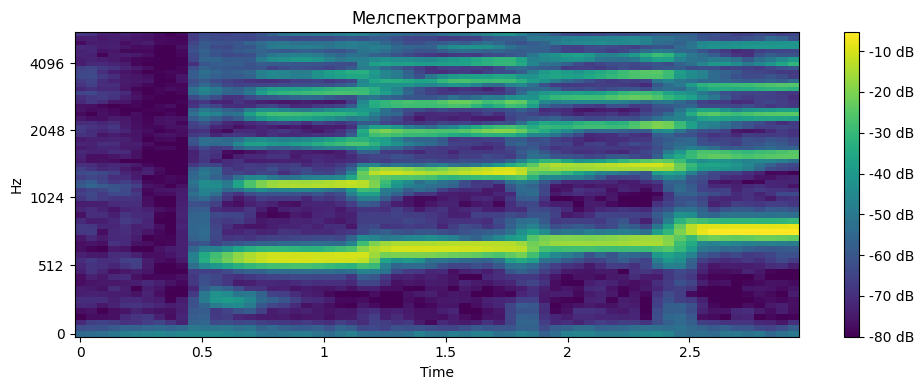

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
cmap = "viridis"

img = librosa.display.specshow(
    sample_x[0].numpy(force=True),
    sr=sample_rate,
    fmax=sample_rate // 2,
    ax=ax,
    x_axis='time',
    y_axis='mel',
    cmap=cmap,
)
ax.set(title='Мелспектрограмма')
ax.label_outer()

fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.tight_layout()
plt.show()

In [93]:
from torch.utils.data import DataLoader

In [94]:
train_loader = DataLoader(train_dset, batch_size=41, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dset, batch_size=41, shuffle=False, num_workers=num_workers)

In [95]:
import time
from sklearn.metrics import accuracy_score, f1_score

In [96]:
start_time = time.time()

n_epoch = 150

set_random_state(random_state)

criterion = nn.CrossEntropyLoss()
network = DummyNetwork()

# можно попробовать другой optimizer, тоже считается улучшением
optimizer = optim.AdamW(network.parameters(), lr=0.001)

train_loss = []
val_loss = []

train_acc = []
train_f1 = []
val_acc = []
val_f1 = []

for e in range(n_epoch):
    print(f'epoch #{e+1}')

    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x)
        outputs.append(output.argmax(axis=1))

        target = y
        targets.append(target)

        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()

    y_true = torch.hstack(targets).numpy(force=True)
    y_pred = torch.hstack(outputs).numpy(force=True)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    train_f1.append(f1)

    print(f'[train] mean loss: {train_loss[-1]}')
    print(f'[train] accuracy:  {acc}')
    print(f'[train] f1-score:  {f1}')

    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
            #optimizer.zero_grad()

            output = network(x)
            outputs.append(output.argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
            #loss.backward()
            #optimizer.step()

        y_true = torch.hstack(targets).numpy(force=True)
        y_pred = torch.hstack(outputs).numpy(force=True)
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')

        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        val_f1.append(f1)
        
        print(f'[val] mean loss:   {val_loss[-1]}')
        print(f'[val] accuracy:    {acc}')
        print(f'[val] f1:    {f1}', end="\n\n")


print(f"Execution time: {(time.time() - start_time):.2f} seconds")

epoch #1

[train] mean loss: 10.09711995855108

[train] accuracy:  0.12538495380554335

[train] f1-score:  0.12458228113395589

[val] mean loss:   5.895708969661167

[val] accuracy:    0.167985927880387

[val] f1:    0.13369827833911302



epoch #2

[train] mean loss: 5.071899542937407

[train] accuracy:  0.21557413110426749

[train] f1-score:  0.21207556508534015

[val] mean loss:   4.82955150944846

[val] accuracy:    0.23131046613896217

[val] f1:    0.19623475639466528



epoch #3

[train] mean loss: 3.81260085105896

[train] accuracy:  0.2864056313242411

[train] f1-score:  0.28346476123654823

[val] mean loss:   3.5399112360818044

[val] accuracy:    0.29815303430079154

[val] f1:    0.2762411978971262



epoch #4

[train] mean loss: 2.8841467859508754

[train] accuracy:  0.3671359436867576

[train] f1-score:  0.3642576403009064

[val] mean loss:   3.430851323263986

[val] accuracy:    0.30782761653474056

[val] f1:    0.29917019246446724



epoch #5

[train] mean loss: 2.5315172

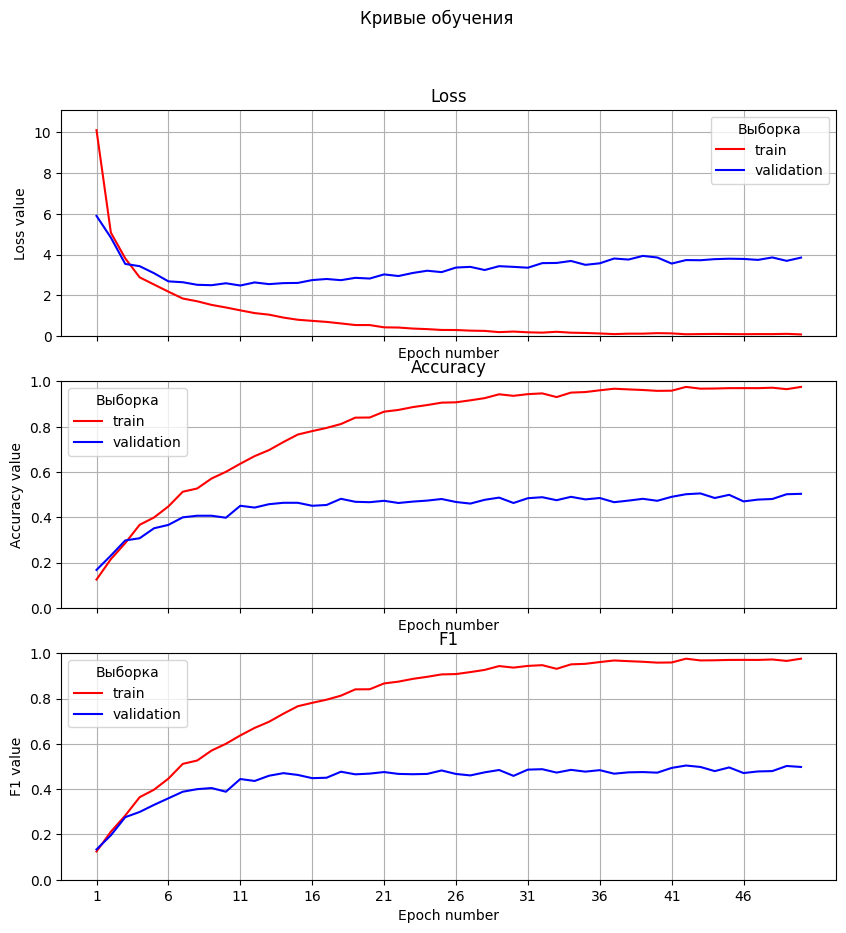

In [97]:
epochs = range(1, n_epoch+1)

fig, (ax_top, ax_bottom, ax_bottom2) = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)

xticks = range(1, n_epoch+1, n_epoch // 10) if n_epoch > 10 else epochs

# draw loss
ax_top.plot(epochs, train_loss, 'r', label='train')
ax_top.plot(epochs, val_loss, 'b', label='validation')

ax_top.set(
    title='Loss',
    xlabel='Epoch number',
    ylabel='Loss value',
    ylim=[0, max(max(train_loss), max(val_loss)) + 1],
)
ax_top.legend(
    title="Выборка",
)
ax_top.grid()

# draw accuracy
ax_bottom.plot(epochs, train_acc, 'r', label='train')
ax_bottom.plot(epochs, val_acc, 'b', label='validation')

ax_bottom.set(
    title='Accuracy',
    xlabel='Epoch number',
    ylabel='Accuracy value',
    xticks=xticks,
    ylim=[0, 1],
)
ax_bottom.legend(
    title="Выборка",
)
ax_bottom.grid()

fig.suptitle("Кривые обучения")

# draw accuracy
ax_bottom2.plot(epochs, train_f1, 'r', label='train')
ax_bottom2.plot(epochs, val_f1, 'b', label='validation')

ax_bottom2.set(
    title='F1',
    xlabel='Epoch number',
    ylabel='F1 value',
    xticks=xticks,
    ylim=[0, 1],
)
ax_bottom2.legend(
    title="Выборка",
)
ax_bottom2.grid()

fig.suptitle("Кривые обучения")

plt.show()

Для каггла

In [73]:
import pandas as pd
df = pd.read_csv(PATH + 'sample_submission.csv')

In [ ]:
arr = df.values
# arr[0, 1] = 2

In [ ]:
f = {}
for i, row in enumerate(pickle_test_data):
    f[row['fname']] = row['feature']

x_test = [prepare_shape(f[name]) for name in df['fname']]
    
test_dset = EventDetectionDataset(x_test, None)

from torch.utils.data import DataLoader

test_loader = DataLoader(test_dset, batch_size=1, shuffle=False, num_workers=num_workers)

In [ ]:
outputs = []
outputs_formated = []

with torch.no_grad():
    for i_batch, sample_batched in enumerate(test_loader):
        x = sample_batched

        output = network(x)
        outputs.append(output.argmax(axis=1))
    
    outputs_formated = torch.hstack(outputs).numpy(force=True)



labeled_outputs = [id_to_label[i] for i in outputs_formated]
print(labeled_outputs)
# id_to_label = [label for label, i in label_to_id.items()]

In [ ]:
arr[:, 1] = labeled_outputs

pd.DataFrame(data=arr, columns=['fname', 'label']).to_csv('submission.csv', index=False)